In [1]:
import os

import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

import h5py
import numpy as np

tf.test.gpu_device_name()

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Loading datasets

In [ ]:
from collections import namedtuple

In [ ]:
Available_models = namedtuple('Model', ['name', 'preprocess_function'])
Xception = Model('Xception', tensorflow.keras.applications.xception.preprocess_input)
DenseNet211 = Model('DenseNet211', tensorflow.keras.applications.densenet.preprocess_input)

In [ ]:
class Model():

    def __init__():


In [3]:
def load_dataset_h5(path, dataset_name):
    with h5py.File(path, "r") as hf:
        print(hf.keys())
        X = hf[dataset_name][:]
        hf.close()
    return X

In [4]:
path = '/content/gdrive/MyDrive/masterDB/train.h5'
path_val = '/content/gdrive/MyDrive/val.h5'

In [5]:
X_train = load_dataset_h5(path, 'X_train')[:7000]
y_train = load_dataset_h5(path, 'y_train')[:7000].reshape((-1,1))

<KeysViewHDF5 ['X_train', 'y_train']>
<KeysViewHDF5 ['X_train', 'y_train']>


In [6]:
X_val = load_dataset_h5(path_val, 'X_val')[:1500]
y_val = load_dataset_h5(path_val, 'y_val')[:1500].reshape((-1,1))

<KeysViewHDF5 ['X_val', 'y_val']>
<KeysViewHDF5 ['X_val', 'y_val']>


In [7]:
from tensorflow.keras.applications import xception, densenet


In [8]:
X_train= densenet.preprocess_input(X_train)
X_val = densenet.preprocess_input(X_val)

# Create model

In [9]:
from tensorflow.keras.applications import Xception, DenseNet201
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
def get_xception()
    base_model = Xception(include_top=False, weights=None, classes=2)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [10]:
def get_densenet():
    base_model = DenseNet201(include_top=False, weights=None, classes=2)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [12]:
model = get_densenet()

In [13]:
# results = model.fit(train_dataset, validation_data=test_dataset, epochs=10)
results = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
219/219 [==============================] - 314s 1s/step - loss: 0.7016 - accuracy: 0.6484 - val_loss: 0.7749 - val_accuracy: 0.5640
Epoch 2/10
219/219 [==============================] - 279s 1s/step - loss: 0.5748 - accuracy: 0.6963 - val_loss: 1.2468 - val_accuracy: 0.5860
Epoch 3/10
219/219 [==============================] - 278s 1s/step - loss: 0.4827 - accuracy: 0.7710 - val_loss: 0.4597 - val_accuracy: 0.7953
Epoch 4/10
219/219 [==============================] - 278s 1s/step - loss: 0.3937 - accuracy: 0.8329 - val_loss: 0.3309 - val_accuracy: 0.8660
Epoch 5/10
219/219 [==============================] - 278s 1s/step - loss: 0.3446 - accuracy: 0.8551 - val_loss: 0.3152 - val_accuracy: 0.8793
Epoch 6/10
219/219 [==============================] - 278s 1s/step - loss: 0.2664 - accuracy: 0.8895 - val_loss: 0.4301 - val_accuracy: 0.8200
Epoch 7/10
219/219 [==============================] - 278s 1s/step - loss: 0.2295 - accuracy: 0.9032 - val_loss: 0.2655 - val_accuracy: 0.9073

## Evaluation

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
saving_dir = "/content/gdrive/MyDrive/fake-faces-detector/exp/models/DenseNet211"
if os.path.exists(saving_dir) == False:
    os.makedirs(saving_dir)

In [19]:
losses = pd.DataFrame(model.history.history)
losses.to_csv(os.path.join(saving_dir, 'losses.csv'))

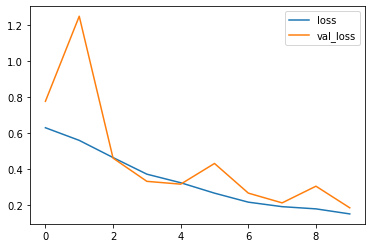

In [20]:
losses[['loss', 'val_loss']].plot()
plt.savefig(os.path.join(saving_dir, 'loss.png'))

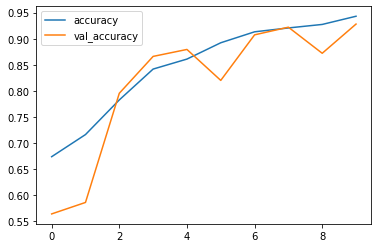

In [21]:
losses[['accuracy', 'val_accuracy']].plot()
plt.savefig(os.path.join(saving_dir, 'acc.png'))

In [22]:
model.save(os.path.join(saving_dir, 'model.h5'))